In [1]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting

from analysis.cardelli import *
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

## EBV_corrections.py

In [9]:
def apply_filt_corrs(no_spectra, yes_spectra, ff, zspec0, FLUX_filt_corr):
    '''
    Applies the filter-based correction.

    Accepts only no/yes_spectra sources with filter matches (based on NAME0).

    For the sources with no_spectra, a log correction factor of 1.28 was added.
    For the ones with a yes_spectra, the relevant filter response .dat file
    was read in to try and find what kind of flux a source with that zspec
    would have in the filter response; a log correction factor of 1 over
    that ratio was then added, with the filter-corrected flux returned.
    '''
    print ff, len(no_spectra)+len(yes_spectra)
    # reading data
    response = asc.read(FULL_PATH+'Filters/'+ff+'response.dat',guess=False,
                    Reader=asc.NoHeader)
    xresponse = np.array(response['col1'])
    xresponse = (xresponse/6563.0)-1                    
    yresponse = np.array(response['col2'])
    yresponse = (yresponse/max(yresponse)) #normalize to 1

    FLUX_filt_corr[no_spectra] += np.log10(1.28)

    good_z = zspec0[yes_spectra]
    for ii in range(len(yes_spectra)):            
        temp = np.array([x for x in range(len(xresponse)-1)
                         if good_z[ii] > xresponse[x]
                         and good_z[ii] < xresponse[x+1]])

        if len(temp) == 0:
            FLUX_filt_corr[yes_spectra[ii]] += np.log10(1.28)
        elif len(temp) > 0:
            avg_y_response = np.mean((yresponse[temp], yresponse[temp+1]))
            FLUX_filt_corr[yes_spectra[ii]] += np.log10(1/avg_y_response)
        #endif
    #endfor
    return FLUX_filt_corr


def apply_filt_corrs2(ff, filt_corrs, zspec0, bad_z, good_z):
    filt_corrs[bad_z] = np.log10(1.28)

    tab0 = asc.read(FULL_PATH+'Filters/'+ff+'response.dat',guess=False,
        Reader=asc.NoHeader)
    z_filt = tab0['col1'].data/6562.8 - 1
    print min(z_filt), max(z_filt)
    print min(zspec0[good_z]), max(zspec0[good_z])

#     if ff=='NB921':
#         print z_filt
#         print zspec0[good_z]
    
    f = interp1d(z_filt, tab0['col2'])
    filt_corrs[good_z] = np.log10(1.0/(f(zspec0[good_z])/max(tab0['col2'])))

    return filt_corrs


def get_nii_corr(allcolsdata, ratio0, ratio1, coverage):
    '''
    Finds the 'good' indexes, where the sources have either full coverage
    or a limit. Those sources are then added to two different arrays,
    with the respective ratios added to an array (NII_corr) that is returned
    at the end.

    The array good_index1 was also returned to show which sources in the
    returned array had full coverage.
    '''
    good_index1 = np.array([])
    good_index2 = np.array([])
    for x in range(len(ratio0)):
        try:
            num0 = float(ratio0[x])
            num1 = float(ratio1[x])
            if num0 != -1. and num0 != 0. and num1 != -1.:
                if coverage[x] == 0:
                    good_index1 = np.append(good_index1, x)
                elif coverage[x] == 1:
                    good_index2 = np.append(good_index2, x)
        except ValueError:
            pass
    #endfor
    good_index1 = np.int_(good_index1)
    good_index2 = np.int_(good_index2)

    NII_corr = np.zeros(len(allcolsdata))
    NII_corr[good_index1] = np.float_(ratio0[good_index1])
    NII_corr[good_index2] = np.float_(ratio0[good_index2])
    return NII_corr, good_index1


def get_nii_line_corr(good_index1, allcolsdata, stlr_mass, ratio0):
    '''
    Creates the line of best fit that is also plotted in
    NII_Ha_MMT_scatter.pdf. Using that line of best-fit, depending on the
    stellar mass of the point, an array of correction factors is returned.
    '''
    nii_corr1 = np.zeros(len(allcolsdata))
    good_stlr = stlr_mass[good_index1]
    good_ratio = np.log10(np.float_(ratio0[good_index1]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(good_stlr,
                                                                   good_ratio)
    for (x, ii) in zip(stlr_mass, range(len(nii_corr1))):
        if x >= max(good_stlr):
            y = slope*max(good_stlr) + intercept
        elif x <= min(good_stlr):
            y = slope*min(good_stlr) + intercept
        else:
            stlr = np.sort(good_stlr)
            match_index = np.array([s for s in range(len(stlr)-1)
                                    if x >= stlr[s] and x <= stlr[s+1]])
            stlr_val=np.mean((stlr[match_index], stlr[match_index+1]))
            y = slope*stlr_val + intercept
        #endif
        nii_corr1[ii] = y
    #endfor
    return 10**nii_corr1


def consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra, data_ns, data_ys, datatype='num'):
    '''
    consolidates no_spectra and yes_spectra data into a single data_array
    of shape orig_fluxes
    '''
    consod = np.zeros(len(orig_fluxes))
    if datatype == 'str':
        consod = np.array(['']*len(orig_fluxes), dtype='|S10')

    consod[no_spectra] = data_ns
    consod[yes_spectra] = data_ys

    return consod


def get_bins(masslist_MMT, masslist_Keck, massZlist_MMT, massZlist_Keck):
    '''
    Helper function for main. Flattens ndarrays of bins into a bins array

    Doesn't include the max_mass as an upper bound to the mass bins so that
    sources that have m > m_max_bin will automatically fall into the highest
    bin.
    Ex:
      >>> x = np.array([5.81, 6.78, 7.12, 7.94, 9.31])
      >>> bins = np.array([6.2, 7.53, 9.31]) 
      >>> np.digitize(x, bins, right=True)
      array([0, 1, 1, 2, 2]) # instead of array([0, 1, 1, 2, 3])
    '''
    massbins_MMT = np.append(masslist_MMT[:,0], masslist_MMT[-1,-1])
    massbins_Keck = np.append(masslist_Keck[:,0], masslist_Keck[-1,-1])
    massZbins_MMT = np.append(massZlist_MMT[:,0], massZlist_MMT[-1,-1])
    massZbins_Keck = np.append(massZlist_Keck[:,0], massZlist_Keck[-1,-1])

    return massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck


def fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, masstype):
    '''
    Fixes masses that were not put into bins because they were too low.
    Reassigns them to the lowest mass bin. 

    Does this for both stlrmass bins and stlrmassZ bins.
    '''
    if masstype=='stlrmass':
        masses_MMT_ii = np.array([1 if x==0 else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array([1 if x==0 else x for x in masses_Keck_ii])
    else: #=='stlrmassZ'
        masses_MMT_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_Keck_ii])

    return masses_MMT_ii, masses_Keck_ii


def bins_table_no_spectra(indexes, NAME0, AP, stlr_mass, massbins_MMT, massbins_Keck, 
    massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck):
    '''
    Creates and returns a table of bins as such:

    NAME             stlrmass filter stlrmassbin_MMT stlrmassbin_Keck stlrmassZbin_MMT stlrmassZbin_Keck
    ---------------- -------- ------ --------------- ---------------- ---------------- -----------------
    Ha-NB973_178201  8.4      NB973  4               3                2-NB973          2-NB973

    WARNINGS: 
    - dual Ha-NB704/Ha-NB711 sources are being treated as Ha-NB704 sources for now, but
      we may have to use photometry to better determine which EBV values to use
    - Ha-NB704+OII-NB973 sources are being treated as Ha-NB704 sources for now, but 
      they may be excluded as they may be something else given the NB973 excess
    '''
    names = NAME0[indexes]
    masses = stlr_mass[indexes]

    # get redshift bins
    filts = np.array([x[x.find('Ha-')+3:x.find('Ha-')+8] for x in names])
    
    # this ensures that NB704+NB921 dual emitters will be placed in Ha-NB921 bins
    #  since these sources are likely OIII-NB704 and Ha-NB921
    dual_iis = [x for x in range(len(names)) if 'Ha-NB704' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_iis] = 'NB921'
    
    # this ensures that the NB816+NB921 dual emitter will be placed in the NB921 bin
    #  we decided this based on visual inspection of the photometry
    dual_ii2 = [x for x in range(len(names)) if 'Ha-NB816' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_ii2] = 'NB921'

    # get stlrmass bins
    masses_MMT_ii = np.digitize(masses, massbins_MMT, right=True)
    masses_Keck_ii = np.digitize(masses, massbins_Keck, right=True)
    masses_MMT, masses_Keck = fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, 'stlrmass')
    
    # get stlrmassZ bins
    ii0 = 0
    ii1 = 0
    massZs_MMT = np.array(['UNFILLED']*len(indexes))
    massZs_Keck = np.array(['UNFILLED']*len(indexes))
    for ff in ['NB704','NB711','NB816','NB921','NB973']:
        jj = len(np.where(ff==massZlist_filts_MMT)[0])        
        
        good_filt_iis = np.array([x for x in range(len(filts)) if filts[x]==ff])
        
        if ff=='NB973':
            jj += 1
        
        mass_MMT_iis  = np.digitize(masses[good_filt_iis], massZbins_MMT[ii0:ii0+jj], right=True)
        massZ_MMT_iis = np.array([str(x)+'-'+ff for x in mass_MMT_iis])
        massZs_MMT[good_filt_iis] = massZ_MMT_iis
        
        ii0+=jj
        if 'NB9' in ff:
            kk = len(np.where(ff==massZlist_filts_Keck)[0])

            if ff=='NB973':
                kk += 1
                
            mass_Keck_iis  = np.digitize(masses[good_filt_iis], massZbins_Keck[ii1:ii1+kk], right=True)
            massZ_Keck_iis = np.array([str(x)+'-'+ff for x in mass_Keck_iis])
            massZs_Keck[good_filt_iis] = massZ_Keck_iis
            
            ii1+=kk
        else:
            massZs_Keck[good_filt_iis] = np.array(['N/A']*len(good_filt_iis))
            masses_Keck[good_filt_iis] = -99
    
    # putting sources with m < m_min_bin in the lowest-massZ mass bin
    massZs_MMT, massZs_Keck = fix_masses_out_of_range(massZs_MMT, massZs_Keck, 'stlrmassZ')

        
    tab0 = Table([names, masses, filts, masses_MMT, masses_Keck, massZs_MMT, massZs_Keck], 
        names=['NAME', 'stlrmass', 'filter', 'stlrmassbin_MMT', 'stlrmassbin_Keck', 
               'stlrmassZbin_MMT', 'stlrmassZbin_Keck'])

    return tab0


def EBV_corrs_no_spectra(tab_no_spectra, mmt_mz, mmt_mz_EBV_hahb, mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb):
    '''
    '''
    EBV_corrs = np.array([-100.0]*len(tab_no_spectra))

    # loop based on filter
    for ff in ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']:
        bin_filt_iis = np.array([x for x in range(len(tab_no_spectra)) if tab_no_spectra['filter'][x]==ff])
        print 'num in '+ff+':', len(bin_filt_iis)

        if ff=='NB704' or ff=='NB711' or ff=='NB816':
            tab_filt_iis = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = mmt_mz_EBV_hahb[tab_filt_iis[m_i]]

        elif ff == 'NB921':
            # for sources that fall within the keck mass range
            bin_filt_iis_keck = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]<=9.78)])
            tab_filt_iis_keck = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_keck = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis_keck]])

            for ii, m_i in enumerate(m_bin_keck):
                EBV_corrs[bin_filt_iis_keck[ii]] = keck_mz_EBV_hahb[tab_filt_iis_keck[m_i]]

            # for sources that fall above the keck mass range (so we use mmt)
            bin_filt_iis_mmt = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]>9.78)])
            tab_filt_iis_mmt = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_mmt = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis_mmt]])

            for ii, m_i in enumerate(m_bin_mmt):
                EBV_corrs[bin_filt_iis_mmt[ii]] = mmt_mz_EBV_hghb[tab_filt_iis_mmt[m_i]]
            
        elif ff == 'NB973':
            tab_filt_iis = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = keck_mz_EBV_hahb[tab_filt_iis[m_i]]
    #endfor

    assert len([x for x in EBV_corrs if x==-100.0]) == 0
    return EBV_corrs


### testing applying filt corrs2

In [6]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays(AP_only = True)
AP = data_dict['AP']
NIIB_Ha_ratios = asc.read(FULL_PATH+'Main_Sequence/Catalogs/line_emission_ratios_table.dat',
    guess=False,Reader=asc.CommentedHeader)
ratio0 = np.array(NIIB_Ha_ratios['NII_Ha_ratio'])
ratio1 = np.array(NIIB_Ha_ratios['OIIIR_HB_ratio'])
coverage = np.array(NIIB_Ha_ratios['POOR_NIIB_COVERAGE'])


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

bad_sources = np.concatenate( [bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
allcolsdata = allcolsdata0[ha_ii]
ratio0 = ratio0[ha_ii]
ratio1 = ratio1[ha_ii]
coverage = coverage[ha_ii]

no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]


# reading in EBV data tables & getting relevant EBV cols
mmt_z   = asc.read(FULL_PATH+'Composite_Spectra/Redshift/MMT_stacked_spectra_data.txt')
mmt_z_EBV_hahb = np.array(mmt_z['E(B-V)_hahb'])
mmt_z_EBV_hghb = np.array(mmt_z['E(B-V)_hghb'])

keck_z  = asc.read(FULL_PATH+'Composite_Spectra/Redshift/Keck_stacked_spectra_data.txt')
keck_z_EBV_hahb = np.array(keck_z['E(B-V)_hahb'])

mmt_m   = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/MMT_all_five_data.txt')
mmt_m_EBV_hahb = np.array(mmt_m['E(B-V)_hahb'])
mmt_m_EBV_hghb = np.array(mmt_m['E(B-V)_hghb'])

keck_m  = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/Keck_all_five_data.txt')
keck_m_EBV_hahb = np.array(keck_m['E(B-V)_hahb'])

mmt_mz  = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/MMT_stlrmassZ_data.txt')
mmt_mz_EBV_hahb = np.array(mmt_mz['E(B-V)_hahb'])
mmt_mz_EBV_hghb = np.array(mmt_mz['E(B-V)_hghb'])

keck_mz = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/Keck_stlrmassZ_data.txt')
keck_mz_EBV_hahb = np.array(keck_mz['E(B-V)_hahb'])


# mass 'bin' lists made by reading in from files generated by the stack plots
masslist_MMT  = np.array([x.split('-') for x in mmt_m['stlrmass_bin']], dtype=float) 
masslist_Keck = np.array([x.split('-') for x in keck_m['stlrmass_bin']], dtype=float)

# same with massZ 'bin' lists (also getting the filts)
massZlist_MMT  = np.array([x.split('-') for x in mmt_mz['stlrmass_bin'] if x!='N/A'], dtype=float)
massZlist_Keck = np.array([x.split('-') for x in keck_mz['stlrmass_bin']], dtype=float)
massZlist_filts_MMT  = np.array([mmt_mz['filter'][x] for x in range(len(mmt_mz)) if mmt_mz['stlrmass_bin'][x]!='N/A'])
massZlist_filts_Keck = np.array([keck_mz['filter'][x] for x in range(len(keck_mz))])

# splitting the 'bin' lists from above into a flattened bins array
massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck = get_bins(masslist_MMT, 
    masslist_Keck, massZlist_MMT, massZlist_Keck)

# getting tables of which bins the sources fall into (for eventual EBV corrections)
tab_no_spectra = bins_table_no_spectra(no_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
tab_yes_spectra = bins_table_no_spectra(yes_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
FILT = consolidate_ns_ys(allcolsdata, no_spectra, yes_spectra,
    np.array(tab_no_spectra['filter']), np.array(tab_yes_spectra['filter']), datatype='str')


# getting filter corrections
#   TODO: redo based on FILT array?? 
#   TODO: correct nb704/nb711 dual emitters for both?
orig_fluxes = np.zeros(len(allcolsdata))
filtcorr_fluxes = np.zeros(len(allcolsdata))
for filt in filtarr:
    filt_ii = np.array([x for x in range(len(FILT)) if filt==FILT[x]])

    no_spectra_temp  = np.array([x for x in filt_ii if x in no_spectra])
    yes_spectra_temp = np.array([x for x in filt_ii if x in yes_spectra])

    orig_fluxes[filt_ii] = allcolsdata[filt+'_FLUX'][filt_ii]
    filtcorr_fluxes[filt_ii] = np.copy(orig_fluxes[filt_ii])
    filtcorr_fluxes = apply_filt_corrs(no_spectra_temp, yes_spectra_temp,
        filt, zspec0, filtcorr_fluxes)
#endfor
filt_corr_factor = filtcorr_fluxes - orig_fluxes

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
NB704 134
NB711 101
NB816 219
NB921 391
something something
the correction is -16.872902914
NB973 236


In [7]:
def get_nii_corr2(allcolsdata, ratio0, ratio1, coverage):
    '''
    Finds the 'good' indexes, where the sources have either full coverage
    or a limit. Those sources are then added to two different arrays,
    with the respective ratios added to an array (NII_corr) that is returned
    at the end.

    The array good_index1 was also returned to show which sources in the
    returned array had full coverage.
    '''
    good_index1 = np.array([])
    good_index2 = np.array([])
    for x in range(len(ratio0)):
        try:
            num0 = float(ratio0[x])
            num1 = float(ratio1[x])
            if num0 != -1. and num0 != 0. and num1 != -1.:
                if coverage[x] == 0:
                    good_index1 = np.append(good_index1, x)
                elif coverage[x] == 1:
                    good_index2 = np.append(good_index2, x)
        except ValueError:
            pass
    #endfor
    good_index1 = np.int_(good_index1)
    good_index2 = np.int_(good_index2)

    NII_corr = np.zeros(len(allcolsdata))
    NII_corr[good_index1] = np.float_(ratio0[good_index1])
    NII_corr[good_index2] = np.float_(ratio0[good_index2])
    return NII_corr, good_index1


def get_nii_line_corr2(good_index1, allcolsdata, stlr_mass, ratio0):
    '''
    Creates the line of best fit that is also plotted in
    NII_Ha_MMT_scatter.pdf. Using that line of best-fit, depending on the
    stellar mass of the point, an array of correction factors is returned.
    '''
    nii_corr1 = np.zeros(len(allcolsdata))
    good_stlr = stlr_mass[good_index1]
    good_ratio = np.log10(np.float_(ratio0[good_index1]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(good_stlr,
                                                                   good_ratio)
    for (x, ii) in zip(stlr_mass, range(len(nii_corr1))):
        if x >= max(good_stlr):
            y = slope*max(good_stlr) + intercept
        elif x <= min(good_stlr):
            y = slope*min(good_stlr) + intercept
        else:
            stlr = np.sort(good_stlr)
            match_index = np.array([s for s in range(len(stlr)-1)
                                    if x >= stlr[s] and x <= stlr[s+1]])
            stlr_val=np.mean((stlr[match_index], stlr[match_index+1]))
            y = slope*stlr_val + intercept
#             print 'original value:', y
            
#             print 'possible other:', slope*x + intercept

            print stlr_val, x
        #endif
        nii_corr1[ii] = y
    #endfor
    return 10**nii_corr1

In [8]:
# getting nii_ha corrections
ratio_vs_line = np.array(['']*len(allcolsdata), dtype='|S10')
nii_ha_ratio = np.zeros(len(allcolsdata))
nii_ha_corr_factor = np.zeros(len(allcolsdata))

nii_corr0, good_index1 = get_nii_corr2(allcolsdata, ratio0, ratio1, coverage)
nii_corr1 = get_nii_line_corr2(good_index1, allcolsdata, stlr_mass, ratio0)

for ii in range(len(nii_corr0)):
    corr_factor = -99
    if nii_corr0[ii] != 0:
        corr_factor = np.log10(1/(1+1.33*nii_corr0[ii]))
        nii_ha_ratio[ii]=nii_corr0[ii]
        ratio_vs_line[ii]='ratio'
    else:
        corr_factor = np.log10(1/(1+1.33*nii_corr1[ii]))
        nii_ha_ratio[ii]=nii_corr1[ii]
        ratio_vs_line[ii]='line'
    #endif
    nii_ha_corr_factor[ii] = corr_factor
#endfor

7.735 7.73
7.815 7.81
8.19 8.2
7.8425 7.84
9.105 9.09
8.4575 8.45
8.57 8.56
7.375 7.4
8.65875 8.66
9.105 9.08
8.08 8.05
8.705 8.71
8.595 8.57
7.965 7.94
8.745 8.73
8.99 8.99
7.965 7.98
9.4625 9.46
8.205 8.21
8.08 8.06
7.8625 7.86
7.49 7.49
7.63 7.62
8.205 8.21
8.1075 8.12
7.63 7.67
8.4325 8.43
7.7 7.69
7.7 7.69
7.815 7.82
8.7925 8.79
9.5175 9.51
7.8625 7.86
8.175 8.17
8.08 8.07
8.26166666667 8.26
9.335 9.33
7.965 7.94
8.16 8.16
8.745 8.74
7.7 7.7
7.76 7.76
8.03 8.03
7.375 7.38
8.305 8.32
7.965 7.96
8.35 8.36
8.08 8.08
8.99 8.99
7.665 7.68
8.19 8.2
7.4325 7.45
7.89 7.89
8.08 8.06
8.5 8.5
8.0225 8.02
8.01 8.01
7.63 7.66
7.7 7.69
7.375 7.43
8.3825 8.38
7.545 7.55
7.815 7.81
9.0 9.0
7.7175 7.72
7.915 7.92
8.83166666667 8.83
7.735 7.74
8.2475 8.25
8.2475 8.25
7.94 7.93
8.4325 8.43
8.475 8.48
8.895 8.87
8.26166666667 8.26
7.785 7.78
8.0225 8.02
8.2475 8.25
8.305 8.31
8.525 8.51
8.08 8.11
7.375 7.33
8.305 8.31
8.19 8.19
7.905 7.9
8.175 8.17
8.205 8.21
8.525 8.52
9.45 9.45
7.825 7.83
9.015 9.0

In [13]:
tab00 = Table([ID0, NAME0, FILT, zspec0, stlr_mass, orig_fluxes, orig_lums, orig_sfr, 
    filt_corr_factor, nii_corr_factor, nii_ha_corr_factor, ratio_vs_line,
    A_V, EBV_corrs, dust_corr_factor], 
    names=['ID', 'NAME0', 'filt', 'zspec0', 'stlr_mass', 'obs_fluxes', 'obs_lumin', 'obs_sfr',
    'filt_corr_factor', 'nii_ha_corr_factor', 'NII_Ha_corr_ratio', 'ratio_vs_line', 
    'A_V', 'EBV', 'dust_corr_factor'])

In [51]:
tab00

ID,NAME0,filt,zspec0,stlr_mass,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_corr_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int32,str67,str10,float64,float64,float32,float64,float64,float64,float64,float64,str10,float64,float64,float64
1,Ha-NB704_001870,NB704,0.0724,7.73,-16.0044,39.1026327827,-2.25501263109,0.00720384306222,0.0583515591063,-0.032460635022,ratio,0.0,0.0,0.0
4,Ha-NB704_005232,NB704,0.0682,6.71,-16.0573,38.9953448837,-2.36230053011,0.119287811513,0.0215428165369,-0.0122684520179,ratio,0.184698824633,0.0728590773569,0.184698824633
6,Ha-NB704_005332,NB704,-10.0,6.78,-17.1989,37.9234719142,-3.43417349957,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
13,Ha-NB704_005572_OIII-IA598_028451,NB704,-10.0,5.81,-16.6327,38.4897465572,-2.86789885662,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
24,Ha-NB704_005882,NB704,-10.0,7.12,-17.2085,37.9139065609,-3.44373885296,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
26,Ha-NB704_005932,NB704,-10.0,5.98,-17.2531,37.8693337307,-3.48831168316,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
30,OIII-NB704_006046_Ha-NB921_020459,NB921,0.3977,7.81,-17.2101,39.5356975492,-1.82194786464,0.0489004639869,0.0617049289104,-0.0342543754135,line,0.287786632896,0.113524645271,0.287786632896
42,OIII-NB704_006189_Ha-NB921_021464,NB921,0.401,8.2,-16.9497,39.8045612852,-1.55308412859,0.170661246198,0.0803579644942,-0.044099007297,line,0.188159369721,0.0742241760398,0.188159369721
54,Ha-NB704_006587,NB704,-10.0,6.48,-17.1835,37.9388623104,-3.41878310345,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633


In [3]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays(AP_only = True)
AP = data_dict['AP']
NIIB_Ha_ratios = asc.read(FULL_PATH+'Main_Sequence/Catalogs/line_emission_ratios_table.dat',
    guess=False,Reader=asc.CommentedHeader)
ratio0 = np.array(NIIB_Ha_ratios['NII_Ha_ratio'])
ratio1 = np.array(NIIB_Ha_ratios['OIIIR_HB_ratio'])
coverage = np.array(NIIB_Ha_ratios['POOR_NIIB_COVERAGE'])


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

bad_sources = np.concatenate( [bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
allcolsdata = allcolsdata0[ha_ii]
ratio0 = ratio0[ha_ii]
ratio1 = ratio1[ha_ii]
coverage = coverage[ha_ii]

no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]


# reading in EBV data tables & getting relevant EBV cols
mmt_z   = asc.read(FULL_PATH+'Composite_Spectra/Redshift/MMT_stacked_spectra_data.txt')
mmt_z_EBV_hahb = np.array(mmt_z['E(B-V)_hahb'])
mmt_z_EBV_hghb = np.array(mmt_z['E(B-V)_hghb'])

keck_z  = asc.read(FULL_PATH+'Composite_Spectra/Redshift/Keck_stacked_spectra_data.txt')
keck_z_EBV_hahb = np.array(keck_z['E(B-V)_hahb'])

mmt_m   = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/MMT_all_five_data.txt')
mmt_m_EBV_hahb = np.array(mmt_m['E(B-V)_hahb'])
mmt_m_EBV_hghb = np.array(mmt_m['E(B-V)_hghb'])

keck_m  = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/Keck_all_five_data.txt')
keck_m_EBV_hahb = np.array(keck_m['E(B-V)_hahb'])

mmt_mz  = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/MMT_stlrmassZ_data.txt')
mmt_mz_EBV_hahb = np.array(mmt_mz['E(B-V)_hahb'])
mmt_mz_EBV_hghb = np.array(mmt_mz['E(B-V)_hghb'])

keck_mz = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/Keck_stlrmassZ_data.txt')
keck_mz_EBV_hahb = np.array(keck_mz['E(B-V)_hahb'])


# mass 'bin' lists made by reading in from files generated by the stack plots
masslist_MMT  = np.array([x.split('-') for x in mmt_m['stlrmass_bin']], dtype=float) 
masslist_Keck = np.array([x.split('-') for x in keck_m['stlrmass_bin']], dtype=float)

# same with massZ 'bin' lists (also getting the filts)
massZlist_MMT  = np.array([x.split('-') for x in mmt_mz['stlrmass_bin'] if x!='N/A'], dtype=float)
massZlist_Keck = np.array([x.split('-') for x in keck_mz['stlrmass_bin']], dtype=float)
massZlist_filts_MMT  = np.array([mmt_mz['filter'][x] for x in range(len(mmt_mz)) if mmt_mz['stlrmass_bin'][x]!='N/A'])
massZlist_filts_Keck = np.array([keck_mz['filter'][x] for x in range(len(keck_mz))])

# splitting the 'bin' lists from above into a flattened bins array
massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck = get_bins(masslist_MMT, 
    masslist_Keck, massZlist_MMT, massZlist_Keck)

# getting tables of which bins the sources fall into (for eventual EBV corrections)
tab_no_spectra = bins_table_no_spectra(no_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
tab_yes_spectra = bins_table_no_spectra(yes_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
FILT = consolidate_ns_ys(allcolsdata, no_spectra, yes_spectra,
    np.array(tab_no_spectra['filter']), np.array(tab_yes_spectra['filter']), datatype='str')


# getting filter corrections
#   TODO: redo based on FILT array?? 
#   TODO: correct nb704/nb711 dual emitters for both?
orig_fluxes = np.zeros(len(allcolsdata))
filtcorr_fluxes = np.zeros(len(allcolsdata))
for filt in filtarr:
    filt_ii = np.array([x for x in range(len(FILT)) if filt==FILT[x]])

    no_spectra_temp  = np.array([x for x in filt_ii if x in no_spectra])
    yes_spectra_temp = np.array([x for x in filt_ii if x in yes_spectra])

    orig_fluxes[filt_ii] = allcolsdata[filt+'_FLUX'][filt_ii]
    filtcorr_fluxes[filt_ii] = np.copy(orig_fluxes[filt_ii])
    filtcorr_fluxes = apply_filt_corrs(no_spectra_temp, yes_spectra_temp,
        filt, zspec0, filtcorr_fluxes)
#endfor
filt_corr_factor = filtcorr_fluxes - orig_fluxes


# getting nii_ha corrections
ratio_vs_line = np.array(['']*len(allcolsdata), dtype='|S10')
nii_ha_ratio = np.zeros(len(allcolsdata))
nii_ha_corr_factor = np.zeros(len(allcolsdata))

nii_corr0, good_index1 = get_nii_corr(allcolsdata, ratio0, ratio1, coverage)
nii_corr1 = get_nii_line_corr(good_index1, allcolsdata, stlr_mass, ratio0)

for ii in range(len(nii_corr0)):
    corr_factor = -99
    if nii_corr0[ii] != 0:
        corr_factor = np.log10(1/(1+1.33*nii_corr0[ii]))
        nii_ha_ratio[ii]=nii_corr0[ii]
        ratio_vs_line[ii]='ratio'
    else:
        corr_factor = np.log10(1/(1+1.33*nii_corr1[ii]))
        nii_ha_ratio[ii]=nii_corr1[ii]
        ratio_vs_line[ii]='line'
    #endif
    nii_ha_corr_factor[ii] = corr_factor
#endfor


# getting the EBV corrections to use
#  yes_spectra originally gets the no_spectra and then individual ones are applied 
#  if S/N is large enough
EBV_corrs_ns = EBV_corrs_no_spectra(tab_no_spectra, mmt_mz, mmt_mz_EBV_hahb,
    mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb)
EBV_corrs_ys = EBV_corrs_no_spectra(tab_yes_spectra, mmt_mz, mmt_mz_EBV_hahb, 
    mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb)
EBV_corrs = consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra,
    EBV_corrs_ns, EBV_corrs_ys)


# getting dust extinction corrections
k_ha = cardelli(6563.0 * u.Angstrom)
A_V = k_ha * EBV_corrs 
dustcorr_fluxes = orig_fluxes + A_V # A_V = A(Ha) = extinction at Ha
dust_corr_factor = dustcorr_fluxes - orig_fluxes


# getting luminosities
filt_cen = [7046, 7162, 8150, 9195, 9755] # angstroms
tempz = np.array([-100.0]*len(no_spectra))
for ff, ii in zip(filtarr, range(len(filt_cen))):
    filt_match = np.array([x for x in range(len(no_spectra)) if tab_no_spectra['filter'][x]==ff])
    tempz[filt_match] = filt_cen[ii]/6562.8 - 1
#endfor
lum_dist_ns = (cosmo.luminosity_distance(tempz).to(u.cm).value)
lum_factor_ns = np.log10(4*np.pi)+2*np.log10(lum_dist_ns) # = log10(L[Ha])
lum_dist_ys = (cosmo.luminosity_distance(zspec0[yes_spectra]).to(u.cm).value)
lum_factor_ys = np.log10(4*np.pi)+2*np.log10(lum_dist_ys)
lum_factors = consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra,
    lum_factor_ns, lum_factor_ys)

orig_lums = orig_fluxes + lum_factors


# # getting SFR
# #  7.9E-42 is conversion btwn L and SFR based on Kennicutt 1998 for Salpeter IMF. 
# #  We use 1.8 to convert to Chabrier IMF.
orig_sfr = np.log10(7.9/1.8) - 42 + orig_lums

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
NB704 134
NB711 101
NB816 219
NB921 391
something something
the correction is -16.872902914
NB973 236
num in NB704: 113
num in NB711: 98
num in NB816: 169
num in NB921: 183
num in NB973: 145
num in NB704: 21
num in NB711: 3
num in NB816: 50
num in NB921: 208
num in NB973: 91


### plotting M* vs EBV?

In [10]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                    Reader=asc.FixedWidthTwoLine)

In [11]:
corr_tbl

ID,NAME0,filt,zspec0,stlr_mass,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
1,Ha-NB704_001870,NB704,0.0724,7.73,-16.0044364929,39.1026327827,-2.25501263109,0.00720384306222,-0.032460635022,0.0583515591063,ratio,0.0,0.0,0.0
4,Ha-NB704_005232,NB704,0.0682,6.71,-16.057264328,38.9953448837,-2.36230053011,0.119287811513,-0.0122684520179,0.0215428165369,ratio,0.184698824633,0.0728590773569,0.184698824633
6,Ha-NB704_005332,NB704,-10.0,6.78,-17.1989383698,37.9234719142,-3.43417349957,0.110400836647,-0.0241161591522,0.0429324888131,line,0.184698824633,0.0728590773569,0.184698824633
13,Ha-NB704_005572_OIII-IA598_028451,NB704,-10.0,5.81,-16.6326637268,38.4897465572,-2.86789885662,0.110400836647,-0.0241161591522,0.0429324888131,line,0.184698824633,0.0728590773569,0.184698824633
24,Ha-NB704_005882,NB704,-10.0,7.12,-17.2085037231,37.9139065609,-3.44373885296,0.110400836647,-0.0241161591522,0.0429324888131,line,0.184698824633,0.0728590773569,0.184698824633
26,Ha-NB704_005932,NB704,-10.0,5.98,-17.2530765533,37.8693337307,-3.48831168316,0.110400836647,-0.0241161591522,0.0429324888131,line,0.184698824633,0.0728590773569,0.184698824633
30,OIII-NB704_006046_Ha-NB921_020459,NB921,0.3977,7.81,-17.1826019287,39.5631519254,-1.79449348842,0.0214460877662,-0.0341385651573,0.0614880049416,line,0.287786632896,0.113524645271,0.287786632896
42,OIII-NB704_006189_Ha-NB921_021464,NB921,0.401,8.2,-16.7791481018,39.9750763456,-1.38256906816,0.000146185772767,-0.0443953063408,0.0809259555056,line,0.188159369721,0.0742241760398,0.188159369721
54,Ha-NB704_006587,NB704,-10.0,6.48,-17.1835479736,37.9388623104,-3.41878310345,0.110400836647,-0.0241161591522,0.0429324888131,line,0.184698824633,0.0728590773569,0.184698824633


In [35]:
ebv00 = np.array(corr_tbl['EBV'])
mstar00 = np.array(corr_tbl['stlr_mass'])

gg = np.where(ebv00 > 0)[0]

ebv01 = ebv00[gg]
mstar01 = mstar00[gg]
zspec01 = np.array(corr_tbl['zspec0'])[gg]

zz = np.array([x for x in range(len(zspec01)) if zspec01[x] > 0 and zspec01[x] < 9])

ebv02 = ebv01[zz]
mstar02 = mstar01[zz]
zspec02 = zspec01[zz]
filt02 = np.array(corr_tbl['filt'][gg][zz])

In [60]:
aa = np.where((corr_tbl['filt']=='NB704') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
bb = np.where((corr_tbl['filt']=='NB711') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
cc = np.where((corr_tbl['filt']=='NB816') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
dd = np.where((corr_tbl['filt']=='NB921') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
ee = np.where((corr_tbl['filt']=='NB973') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))

In [37]:
nb704 = np.where(filt02=='NB704')[0]
nb711 = np.where(filt02=='NB711')[0]
nb816 = np.where(filt02=='NB816')[0]
nb921 = np.where(filt02=='NB921')[0]
nb973 = np.where(filt02=='NB973')[0]

(-0.02, 0.30000000000000004)

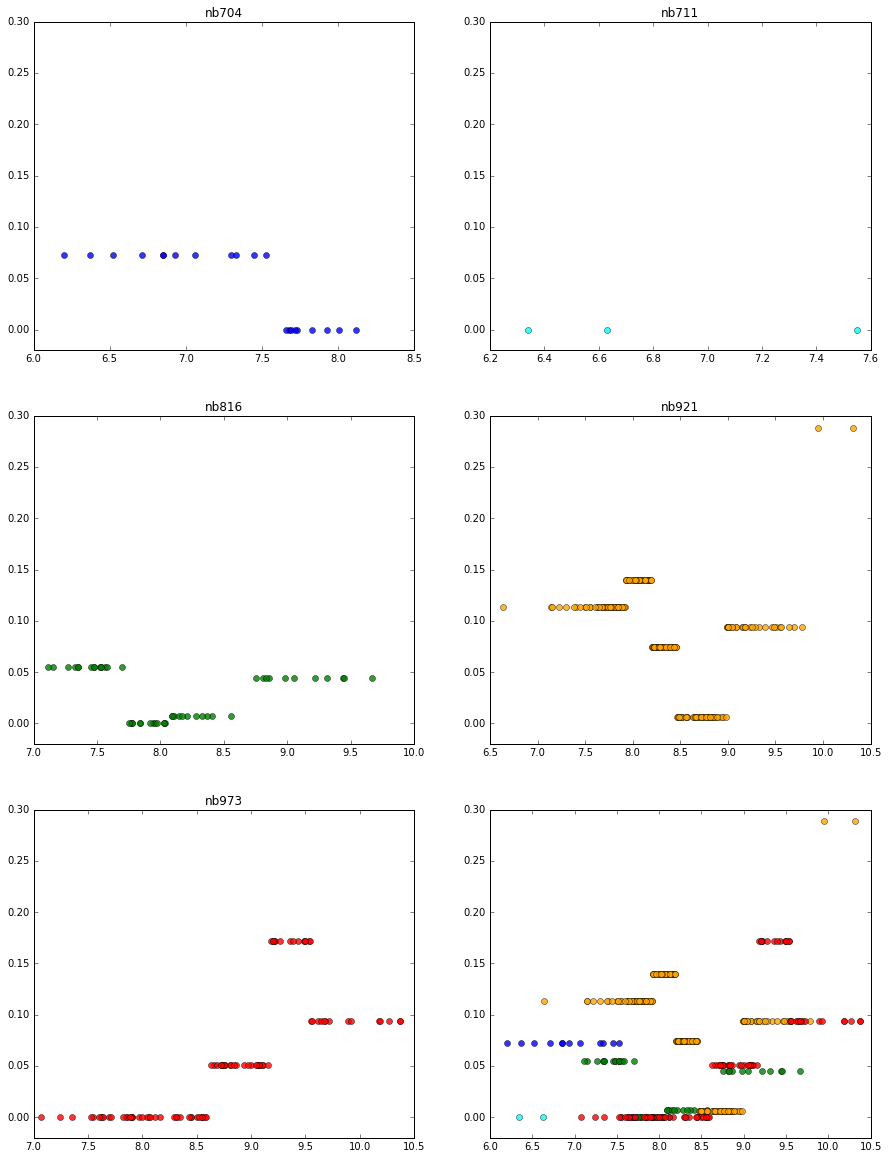

In [83]:
f, axes = plt.subplots(3,2)
f.set_size_inches(15,20)

axarr = np.ndarray.flatten(axes)

for ax, ii, lab, color in zip(axarr, [aa,bb,cc,dd,ee], 
                         ['nb704','nb711','nb816','nb921','nb973'], ['blue','cyan','green','orange','red']):
    ax.plot(mstar00[ii], ebv00[ii], color, marker='o', ls='None', label=lab, alpha=0.8)
    ax.set_ylim([-0.02, 0.3])
    ax.set_title(lab)
    
axarr[-1].plot(mstar00[aa], ebv00[aa], 'blue', marker='o', ls='None', label='nb704', alpha=0.8)
axarr[-1].plot(mstar00[bb], ebv00[bb], 'cyan', marker='o', ls='None', label='nb711', alpha=0.8)
axarr[-1].plot(mstar00[cc], ebv00[cc], 'green', marker='o', ls='None', label='nb816', alpha=0.8)
axarr[-1].plot(mstar00[dd], ebv00[dd], 'orange', marker='o', ls='None', label='nb921', alpha=0.8)
axarr[-1].plot(mstar00[ee], ebv00[ee], 'red', marker='o', ls='None', label='nb973', alpha=0.8)
axarr[-1].set_ylim(ymin=-0.02)

In [87]:
nbiadata.columns

ColDefs(
    name = 'ID'; format = 'J'; disp = 'I5'
    name = 'NAME'; format = '67A'
    name = 'RA'; format = 'D'; disp = 'F10.6'
    name = 'DEC'; format = 'D'; disp = 'F10.6'
    name = 'EXCESS'; format = 'E'; disp = 'F7.4'
    name = 'ZPHOT'; format = 'E'; disp = 'F7.4'
    name = 'MASS'; format = 'E'; disp = 'F7.3'
    name = 'LSFR'; format = 'E'; disp = 'F7.3'
    name = 'LSSFR'; format = 'E'; disp = 'F7.3'
    name = 'EW'; format = 'E'
    name = 'FLUX'; format = 'E'; disp = 'F7.4'
    name = 'NB'; format = 'E'; disp = 'F7.4'
)

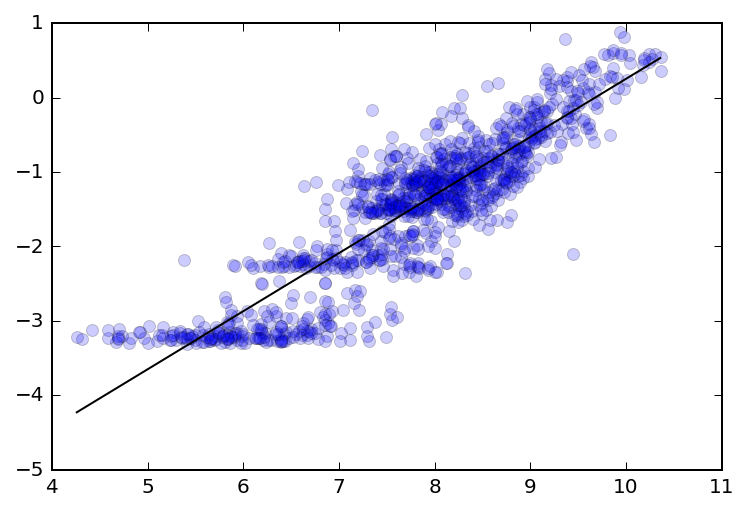

In [398]:
# from scipy.optimize import curve_fit

# def line(x, m, b):
#     return m*x + b

# xarr = np.concatenate((stlr_mass[no_spectra], stlr_mass[yes_spectra]))
# yarr = np.concatenate((dustcorr_sfrs_ns, dustcorr_sfrs_ys))

# coeffs, covar = curve_fit(line, xarr, yarr)
# coeffs
# xx = np.arange(min(xarr), max(xarr), 0.1)

# plt.plot(xarr, yarr, 'bo', alpha=0.2)
# plt.plot(xx, line(xx, *coeffs), 'k')
# plt.show()

In [92]:
"""
NAME:
    create_ordered_AP_arrays

PURPOSE:
    This code cross-references all of the data in different
    fits files and orders the relevant data in the standard
    9264 order. Meant to be used as a module.

INPUTS:
    'Catalogs/nb_ia_zspec.txt'
    'Main_Sequence/Catalogs/MMT/MMTS_all_line_fit.fits'
    'Main_Sequence/Catalogs/MMT/MMT_single_line_fit.fits'
    'Main_Sequence/Catalogs/Keck/DEIMOS_single_line_fit.fits'
    'Main_Sequence/Catalogs/Keck/DEIMOS_00_all_line_fit.fits'
    'Main_Sequence/Catalogs/merged/MMT_Keck_line_fit.fits'

OUTPUTS:
    A dictionary with ordered AP, <instr>_LMIN0/LMAX0 arrays as values
"""

import numpy as np
from astropy.io import fits as pyfits, ascii as asc

def make_AP_arr_MMT(slit_str0):
    '''
    Creates an AP (aperture) array with the slit_str0 input from
    nb_ia_zspec.txt. At the indexes of the slit_str0 where there existed a
    type of AP ('N/A', 'S./A./D./1./2./3./4.###'), the indexes of the new
    AP array were replaced with those values with the remaining values
    renamed as 'not_MMT' before the array was returned.

    Takes care of N/A and MMT,
    '''
    AP = np.array(['x.xxx']*len(slit_str0))

    #N/A
    slit_NA_index = np.array([x for x in range(len(slit_str0))
                              if slit_str0[x] == 'N/A'])
    AP[slit_NA_index] = slit_str0[slit_NA_index]

    #MMT,
    slit_S_index  = np.array([x for x in range(len(slit_str0))
                              if 'S.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_S_index] = slit_str0[slit_S_index]

    slit_A_index  = np.array([x for x in range(len(slit_str0))
                              if 'A.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_A_index] = slit_str0[slit_A_index]
    
    slit_D_index  = np.array([x for x in range(len(slit_str0))
                              if 'D.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_D_index] = slit_str0[slit_D_index]
    
    slit_1_index  = np.array([x for x in range(len(slit_str0))
                              if '1.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_1_index] = slit_str0[slit_1_index]
    
    slit_2_index  = np.array([x for x in range(len(slit_str0))
                              if '2.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_2_index] = slit_str0[slit_2_index]
    
    slit_3_index  = np.array([x for x in range(len(slit_str0))
                              if '3.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_3_index] = slit_str0[slit_3_index]
    
    slit_4_index  = np.array([x for x in range(len(slit_str0))
                              if '4.' == slit_str0[x][:2] and
                              len(slit_str0[x])==6], dtype=np.int32)
    AP[slit_4_index] = slit_str0[slit_4_index]

    bad_index = np.array([x for x in range(len(AP)) if AP[x] == 'x.xxx'])
    APgood = np.array(AP, dtype='|S20')
    APgood[bad_index] = 'not_MMT'
    
    return APgood


def make_AP_arr_DEIMOS(AP, slit_str0):
    '''
    Accepts the AP array made by make_AP_arr_MMT and the slit_str0 array.
    Then, at the indices of slit_str0 where '##.###' exists (that's not a
    FOCAS detection), those indices of the AP array are replaced and then
    after modification is done, returned.

    Those with '08.' as a detection were ignored for now.

    Takes care of Keck, and Keck,Keck,
    '''

    #Keck,
    temp_index1 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x]) == 7 and 'f' not in slit_str0[x]
                            and '08.'!=slit_str0[x][:3]])
    AP[temp_index1] = slit_str0[temp_index1]
    AP[temp_index1] = np.array([x[:6] for x in AP[temp_index1]])

    temp_index2 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x]) == 7 and 'f' not in slit_str0[x]
                            and '08.'==slit_str0[x][:3]])
    AP[temp_index2] = 'INVALID_KECK'

    #Keck,Keck,
    temp_index3 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==14 and 'f' not in slit_str0[x]
                            and '08.'==slit_str0[x][7:10] and
                            '08.'==slit_str0[x][:3]])
    AP[temp_index3] = 'INVALID_KECK'

    temp_index4 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==14 and 'f' not in slit_str0[x]
                            and '08.'==slit_str0[x][:3] and
                            '08.'!=slit_str0[x][7:10]])
    AP[temp_index4] = slit_str0[temp_index4]
    AP[temp_index4] = np.array([x[7:13] for x in AP[temp_index4]])
    
    return AP


def make_AP_arr_merged(AP, slit_str0):
    '''
    Accepts the AP array made by make_AP_arr_DEIMOS and the slit_str0 array.
    Then, at the indices where there were multiple detections (not including
    a FOCAS detection), those indices were replaced and returned.

    Takes care of merged, and MMT,Keck, and merged,FOCAS,
    '''

    #merged,
    temp_index1 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x]) == 13 and slit_str0[x][5] == ','
                            and 'f' not in slit_str0[x] and
                            '08.'!= slit_str0[x][6:9]])
    AP[temp_index1] = slit_str0[temp_index1]
    AP[temp_index1] = np.array([x[:12] for x in AP[temp_index1]])

    #MMT,Keck, means MMT,
    temp_index2 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x]) == 13 and slit_str0[x][5] == ','
                            and 'f' not in slit_str0[x] and
                            '08.'== slit_str0[x][6:9]])
    AP[temp_index2] = slit_str0[temp_index2]
    AP[temp_index2] = np.array([x[:5] for x in AP[temp_index2]])

    #merged,FOCAS,
    temp_index3 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x]) > 13 and 'f'==slit_str0[x][13]
                            and '08.' not in slit_str0[x][:13]], dtype=np.int32)
    AP[temp_index3] = slit_str0[temp_index3]
    AP[temp_index3] = np.array([x[:12] for x in AP[temp_index3]])
    
    return AP


def make_AP_arr_FOCAS(AP, slit_str0):
    '''
    Accepts the AP array made by make_AP_arr_DEIMOS and the slit_str0 array.
    Same idea as the other make_AP_arr functions.

    Takes care of FOCAS, and FOCAS,FOCAS,FOCAS, and FOCAS,FOCAS, and
    MMT,FOCAS, and Keck,FOCAS, and Keck,Keck,FOCAS, and Keck,FOCAS,FOCAS,
    '''

    #FOCAS,
    temp_index1 = np.array([x for x in range(len(slit_str0)) if
                            'f'==slit_str0[x][0] and len(slit_str0[x])==7],
                           dtype=np.int32)
    AP[temp_index1] = 'FOCAS'

    #FOCAS,FOCAS,FOCAS,
    temp_index2 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==21 and 'f'==slit_str0[x][0] and
                            'f'==slit_str0[x][7] and 'f'==slit_str0[x][14]])
    AP[temp_index2] = 'FOCAS'

    #FOCAS,FOCAS,
    temp_index3 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==14 and 'f'==slit_str0[x][0] and
                            'f'==slit_str0[x][7]])
    AP[temp_index3] = 'FOCAS'

    #MMT,FOCAS,
    temp_index4 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==13 and 'f'==slit_str0[x][6]])
    AP[temp_index4] = slit_str0[temp_index4]
    AP[temp_index4] = np.array([x[:5] for x in AP[temp_index4]])

    #Keck,FOCAS,
    temp_index5 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==14 and 'f'==slit_str0[x][7] and
                            'f' not in slit_str0[x][:6]])
    AP[temp_index5] = slit_str0[temp_index5]
    AP[temp_index5] = np.array([x[:6] for x in AP[temp_index5]])

    #Keck,Keck,FOCAS,
    temp_index6 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==21 and 'f'==slit_str0[x][14] and
                            'f' not in slit_str0[x][:13] and
                            '08.'==slit_str0[x][:3]])
    AP[temp_index6] = slit_str0[temp_index6]
    AP[temp_index6] = np.array([x[7:13] for x in AP[temp_index6]])

    #Keck,FOCAS,FOCAS,
    temp_index7 = np.array([x for x in range(len(slit_str0)) if
                            len(slit_str0[x])==21 and 'f' not in
                            slit_str0[x][:6] and 'f'==slit_str0[x][7] and
                            'f'==slit_str0[x][14]])
    AP[temp_index7] = slit_str0[temp_index7]
    AP[temp_index7] = np.array([x[:6] for x in AP[temp_index7]])
    
    return AP


def get_LMIN0_LMAX0(all_AP, detect_AP, all_MMT_LMIN0, detect_MMT_LMIN0,
    all_MMT_LMAX0, detect_MMT_LMAX0, all_KECK_LMIN0, detect_KECK_LMIN0,
    all_KECK_LMAX0, detect_KECK_LMAX0):
    '''
    Accepts, modifies, and returns '<instr>_LMIN0/LMAX0' (passed in as 'all_<__>').
    'all_AP' is the complete AP column with all the information, while
    'detect_AP' and every input subsequent until the last four are the arrays
    specific to the Main_Sequence catalog.

    There are 5 different types of catalogs, so this method is called 5 times.

    This method looks at the indices where the detect_AP is in the all_AP and
    appends the overlapping indices of the all_AP array. Then, at those
    overlapping indices, the zero values in all_AP are replaced by the
    corresponding detected values.
    '''
    # indexes of data that correspond to indexes in 9264-AP-ordering
    index1 = np.array([x for x in range(len(detect_AP)) if detect_AP[x]
                       in all_AP], dtype=np.int32)

    # indexes of 9264-AP-ordering that correspond to indexes in data
    index2 = np.array([])
    for mm in range(len(detect_AP)):
        index2 = np.append(index2, np.where(all_AP == detect_AP[mm])[0])
    #endfor
    index2 = np.array(index2, dtype=np.int32)

    all_MMT_LMIN0[index2] = detect_MMT_LMIN0[index1]
    all_MMT_LMAX0[index2] = detect_MMT_LMAX0[index1]
    all_KECK_LMIN0[index2] = detect_KECK_LMIN0[index1]
    all_KECK_LMAX0[index2] = detect_KECK_LMAX0[index1]

    return all_MMT_LMIN0,all_MMT_LMAX0,all_KECK_LMIN0,all_KECK_LMAX0
#enddef


def get_LMIN0_LMAX0_merged(all_AP, mergedAP, all_MMT_LMIN0, all_MMT_LMAX0, all_KECK_LMIN0,
    all_KECK_LMAX0, MMTallAP, MMTallLMIN0, MMTallLMAX0, MMTsingleAP,
    MMTsingleLMIN0, MMTsingleLMAX0, DEIMOSAP, DEIMOSLMIN0, DEIMOSLMAX0,
    DEIMOS00AP, DEIMOS00LMIN0, DEIMOS00LMAX0):
    '''
    '''
    for ii in range(len(mergedAP)):
        bothap = mergedAP[ii]
        mmt = bothap.split(',')[0]
        keck = bothap.split(',')[1]

        # index in 9264-ordering corresponding to index in data
        jj = [x for x in range(len(all_AP)) if mmt==all_AP[x][:5]]

        # below: index in data corresponding to index in 9264-ordering
        # mmt part
        m1 = [x for x in range(len(MMTallAP)) if mmt==MMTallAP[x]]
        m2 = [x for x in range(len(MMTsingleAP)) if mmt==MMTsingleAP[x]]

        if len(m1) > 0:
            all_MMT_LMIN0[jj] = MMTallLMIN0[m1]
            all_MMT_LMAX0[jj] = MMTallLMAX0[m1]
        elif len(m2) > 0:
            all_MMT_LMIN0[jj] = MMTsingleLMIN0[m2]
            all_MMT_LMAX0[jj] = MMTsingleLMAX0[m2]

        # keck part
        k1 = [x for x in range(len(DEIMOSAP)) if keck==DEIMOSAP[x]]
        k2 = [x for x in range(len(DEIMOS00AP)) if keck==DEIMOS00AP[x]]
        if len(k1) > 0:
            all_KECK_LMIN0[jj] = DEIMOSLMIN0[k1]
            all_KECK_LMAX0[jj] = DEIMOSLMAX0[k1]
        elif len(k2) > 0:
            all_KECK_LMIN0[jj] = DEIMOS00LMIN0[k2]
            all_KECK_LMAX0[jj] = DEIMOS00LMAX0[k2]
    #endfor


    return all_MMT_LMIN0,all_MMT_LMAX0,all_KECK_LMIN0,all_KECK_LMAX0


def get_SNRs(all_AP, detect_AP, all_NIIBSNR, detect_NIIBSNR,
    all_HASNR, detect_HASNR, all_HBSNR, detect_HBSNR,
    all_HGSNR, detect_HGSNR):
    '''
    Accepts, modifies, and returns '<line>_SNR' (passed in as 'all_<__>').
    'all_AP' is the complete AP column with all the information, while
    'detect_AP' and every input subsequent until the last four are the arrays
    specific to the Main_Sequence catalog.

    There are 5 different types of catalogs, so this method is called 5 times.

    This method looks at the indices where the detect_AP is in the all_AP and
    appends the overlapping indices of the all_AP array. Then, at those
    overlapping indices, the zero values in all_AP are replaced by the
    corresponding detected values.
    '''
    # indexes of data that correspond to indexes in 9264-AP-ordering
    index1 = np.array([x for x in range(len(detect_AP)) if detect_AP[x]
                       in all_AP], dtype=np.int32)

    # indexes of 9264-AP-ordering that correspond to indexes in data
    index2 = np.array([])
    for mm in range(len(detect_AP)):
        index2 = np.append(index2, np.where(all_AP == detect_AP[mm])[0])
    #endfor
    index2 = np.array(index2, dtype=np.int32)

    all_NIIBSNR[index2] = detect_NIIBSNR[index1]
    all_HASNR[index2] = detect_HASNR[index1]
    all_HBSNR[index2] = detect_HBSNR[index1]
    all_HGSNR[index2] = detect_HGSNR[index1]

    return all_NIIBSNR,all_HASNR,all_HBSNR,all_HGSNR


def create_ordered_AP_arrays(AP_only=False):
    '''
    Reads relevant inputs, combining all of the input data into one ordered
    array for AP by calling make_AP_arr_MMT, make_AP_arr_DEIMOS,
    make_AP_arr_merged, and make_AP_arr_FOCAS. 

    Using the AP order, then creates '9264'-ordered arrays
    '''

    zspec = asc.read('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Catalogs/nb_ia_zspec.txt',guess=False,
                     Reader=asc.CommentedHeader)
    slit_str0 = np.array(zspec['slit_str0'])
    inst_str0 = np.array(zspec['inst_str0'])

    MMTall = pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/MMT/MMTS_all_line_fit.fits')
    MMTalldata = MMTall[1].data
    MMTallAP = MMTalldata['AP']
    MMTallLMIN0 = MMTalldata['LMIN0']
    MMTallLMAX0 = MMTalldata['LMAX0']
    MMTallNIIBSNR = MMTalldata['NIIB_SNR']
    MMTallHASNR = MMTalldata['HA_SNR']
    MMTallHBSNR = MMTalldata['HB_SNR']
    MMTallHGSNR = MMTalldata['HG_SNR']

    MMTsingle = pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/MMT/MMT_single_line_fit.fits')
    MMTsingledata = MMTsingle[1].data
    MMTsingleAP = MMTsingledata['AP']
    MMTsingleLMIN0 = MMTsingledata['LMIN0']
    MMTsingleLMAX0 = MMTsingledata['LMAX0']
    MMTsingleNIIBSNR = MMTsingledata['NIIB_SNR']
    MMTsingleHASNR = MMTsingledata['HA_SNR']
    MMTsingleHBSNR = MMTsingledata['HB_SNR']
    MMTsingleHGSNR = MMTsingledata['HG_SNR']

    DEIMOS = pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/Keck/DEIMOS_single_line_fit.fits')
    DEIMOSdata = DEIMOS[1].data
    DEIMOSAP = DEIMOSdata['AP']
    DEIMOSLMIN0 = DEIMOSdata['LMIN0']
    DEIMOSLMAX0 = DEIMOSdata['LMAX0']
    DEIMOSNIIBSNR = DEIMOSdata['NIIB_SNR']
    DEIMOSHASNR = DEIMOSdata['HA_SNR']
    DEIMOSHBSNR = DEIMOSdata['HB_SNR']
    DEIMOSHGSNR = DEIMOSdata['HG_SNR']

    DEIMOS00=pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/Keck/DEIMOS_00_all_line_fit.fits')
    DEIMOS00data = DEIMOS00[1].data
    DEIMOS00AP = DEIMOS00data['AP']
    DEIMOS00LMIN0 = DEIMOS00data['LMIN0']
    DEIMOS00LMAX0 = DEIMOS00data['LMAX0']
    DEIMOS00NIIBSNR = DEIMOS00data['NIIB_SNR']
    DEIMOS00HASNR = DEIMOS00data['HA_SNR']
    DEIMOS00HBSNR = DEIMOS00data['HB_SNR']
    DEIMOS00HGSNR = DEIMOS00data['HG_SNR']

    merged = pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/merged/MMT_Keck_line_fit.fits')
    mergeddata = merged[1].data
    mergedAP = mergeddata['AP']
    mergedLMIN0_MMT = mergeddata['MMT_LMIN0']
    mergedLMAX0_MMT = mergeddata['MMT_LMAX0']
    mergedLMIN0_KECK = mergeddata['KECK_LMIN0']
    mergedLMAX0_KECK = mergeddata['KECK_LMAX0']
    mergedNIIBSNR = mergeddata['NIIB_SNR']
    mergedHASNR = mergeddata['HA_SNR']
    mergedHBSNR = mergeddata['HB_SNR']
    mergedHGSNR = mergeddata['HG_SNR']

    #end inputs
    print '### done reading input files'

    print '### creating ordered AP arr'
    AP0 = make_AP_arr_MMT(slit_str0)
    AP1 = make_AP_arr_DEIMOS(AP0, slit_str0)
    AP2 = make_AP_arr_merged(AP1, slit_str0)
    AP  = make_AP_arr_FOCAS(AP2, slit_str0)
    print '### done creating ordered AP arr'

    merged_iis = np.array([x for x in range(len(inst_str0)) if 'merged' in inst_str0[x]])
    AP_merged = AP[merged_iis]

    if (AP_only == True):
        MMTall.close()
        MMTsingle.close()
        DEIMOS.close()
        DEIMOS00.close()
        merged.close()

        return {'AP': AP}
    #endif 

    print '### creating ordered LMIN0/LMAX0 arrs'
    MMT_LMIN0 = np.array([-99.99999]*len(AP))
    MMT_LMAX0 = np.array([-99.99999]*len(AP))
    KECK_LMIN0 = np.array([-99.99999]*len(AP))
    KECK_LMAX0 = np.array([-99.99999]*len(AP))
    MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0 = get_LMIN0_LMAX0(AP, MMTallAP, MMT_LMIN0, MMTallLMIN0, 
        MMT_LMAX0, MMTallLMAX0, KECK_LMIN0, MMTallLMIN0, KECK_LMAX0, MMTallLMAX0)
    MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0 = get_LMIN0_LMAX0(AP, MMTsingleAP, MMT_LMIN0, MMTsingleLMIN0, 
        MMT_LMAX0, MMTsingleLMAX0, KECK_LMIN0, MMTsingleLMIN0, KECK_LMAX0, MMTsingleLMAX0)
    MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0 = get_LMIN0_LMAX0(AP, DEIMOSAP, MMT_LMIN0, DEIMOSLMIN0, 
        MMT_LMAX0, DEIMOSLMAX0, KECK_LMIN0, DEIMOSLMIN0, KECK_LMAX0, DEIMOSLMAX0)
    MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0 = get_LMIN0_LMAX0(AP, DEIMOS00AP, MMT_LMIN0, DEIMOS00LMIN0, 
        MMT_LMAX0, DEIMOS00LMAX0, KECK_LMIN0, DEIMOS00LMIN0, KECK_LMAX0, DEIMOS00LMAX0)
    MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0 = get_LMIN0_LMAX0_merged(AP, AP_merged, 
        MMT_LMIN0, MMT_LMAX0, KECK_LMIN0, KECK_LMAX0, MMTallAP, MMTallLMIN0, MMTallLMAX0, 
        MMTsingleAP, MMTsingleLMIN0, MMTsingleLMAX0, DEIMOSAP, DEIMOSLMIN0, DEIMOSLMAX0, 
        DEIMOS00AP, DEIMOS00LMIN0, DEIMOS00LMAX0)
    print '### done creating ordered LMIN0/LMAX0 arr'

    print '### creating ordered SNR arrs'
    NIIB_SNR = np.array([-99.99999]*len(AP))
    HA_SNR = np.array([-99.99999]*len(AP))
    HB_SNR = np.array([-99.99999]*len(AP))
    HG_SNR = np.array([-99.99999]*len(AP))
    NIIB_SNR, HA_SNR, HB_SNR, HG_SNR = get_SNRs(AP, MMTallAP, NIIB_SNR, MMTallNIIBSNR, 
        HA_SNR, MMTallHASNR, HB_SNR, MMTallHBSNR, HG_SNR, MMTallHGSNR)
    NIIB_SNR, HA_SNR, HB_SNR, HG_SNR = get_SNRs(AP, MMTsingleAP, NIIB_SNR, MMTsingleNIIBSNR, 
        HA_SNR, MMTsingleHASNR, HB_SNR, MMTsingleHBSNR, HG_SNR, MMTsingleHGSNR)
    NIIB_SNR, HA_SNR, HB_SNR, HG_SNR = get_SNRs(AP, DEIMOSAP, NIIB_SNR, DEIMOSNIIBSNR, 
        HA_SNR, DEIMOSHASNR, HB_SNR, DEIMOSHBSNR, HG_SNR, DEIMOSHGSNR)
    NIIB_SNR, HA_SNR, HB_SNR, HG_SNR = get_SNRs(AP, DEIMOS00AP, NIIB_SNR, DEIMOS00NIIBSNR, 
        HA_SNR, DEIMOS00HASNR, HB_SNR, DEIMOS00HBSNR, HG_SNR, DEIMOS00HGSNR)
    NIIB_SNR, HA_SNR, HB_SNR, HG_SNR = get_SNRs(AP, mergedAP, NIIB_SNR, mergedNIIBSNR, 
        HA_SNR, mergedHASNR, HB_SNR, mergedHBSNR, HG_SNR, mergedHGSNR)
    print '### done creating ordered SNR arrs'

    MMTall.close()
    MMTsingle.close()
    DEIMOS.close()
    DEIMOS00.close()
    merged.close()

    return {'AP': AP, 'MMT_LMIN0': MMT_LMIN0, 'MMT_LMAX0': MMT_LMAX0, 'KECK_LMIN0': KECK_LMIN0, 'KECK_LMAX0': KECK_LMAX0, 'NIIB_SNR': NIIB_SNR, 'HA_SNR': HA_SNR, 'HB_SNR': HB_SNR, 'HG_SNR': HG_SNR}

In [94]:
dd = create_ordered_AP_arrays()

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs


In [95]:
dd

{'AP': array(['S.001', 'S.221', 'N/A', ..., 'N/A', 'N/A', 'N/A'], 
       dtype='|S20'),
 'HA_SNR': array([ 34.27500534,  -1.        , -99.99999   , ..., -99.99999   ,
        -99.99999   , -99.99999   ]),
 'HB_SNR': array([  6.87825823,  31.77065468, -99.99999   , ..., -99.99999   ,
        -99.99999   , -99.99999   ]),
 'HG_SNR': array([ -0.79391778,   9.17941666, -99.99999   , ..., -99.99999   ,
        -99.99999   , -99.99999   ]),
 'KECK_LMAX0': array([ 8571.36914062,  6374.18701172,   -99.99999   , ...,   -99.99999   ,
          -99.99999   ,   -99.99999   ]),
 'KECK_LMIN0': array([ 3406.27587891,  2495.7824707 ,   -99.99999   , ...,   -99.99999   ,
          -99.99999   ,   -99.99999   ]),
 'MMT_LMAX0': array([ 8571.36914062,  6374.18701172,   -99.99999   , ...,   -99.99999   ,
          -99.99999   ,   -99.99999   ]),
 'MMT_LMIN0': array([ 3406.27587891,  2495.7824707 ,   -99.99999   , ...,   -99.99999   ,
          -99.99999   ,   -99.99999   ]),
 'NIIB_SNR': array([  1.673522

In [110]:
tt00 = Table([dd['NIIB_SNR'], dd['HA_SNR'], dd['HB_SNR'], dd['HG_SNR']], names=['NIIB_SNR', 'HA_SNR', 'HB_SNR', 'HG_SNR'])
tt00

NIIB_SNR,HA_SNR,HB_SNR,HG_SNR
float64,float64,float64,float64
1.67352283001,34.2750053406,6.8782582283,-0.793917775154
-1.0,-1.0,31.7706546783,9.17941665649
-99.99999,-99.99999,-99.99999,-99.99999
1.60852777958,92.8383712769,25.3844051361,9.31649017334
-99.99999,-99.99999,-99.99999,-99.99999
-99.99999,-99.99999,-99.99999,-99.99999
-99.99999,-99.99999,-99.99999,-99.99999
-99.99999,-99.99999,-99.99999,-99.99999
-99.99999,-99.99999,-99.99999,-99.99999
